# validation of quantities

In [21]:
import pickle
K = 4
L = 12
with open('../data/avnssDPD.pkl', 'rb') as f:
    avnssDPD = pickle.load(f)
with open('../data/neutralsets_NDPD.pkl', 'rb') as f:
    neutralsetsNDPD = pickle.load(f)

In [31]:
listav = []
listND = []
for key,val in avnssDPD.items():
    print(key,val)
    listav.append(val/K**L)
    listND.append(neutralsetsNDPD[key]/K**L)


............ 15361761.448333334
...(.....).. 13216651.906666666
.(........). 13271678.754999997
((.......)). 11108482.151666667
..(((...))). 8756771.642500002
..((.....)). 11123392.513333334
...(....)... 13132928.633333337
..((......)) 10879666.491666663
..(......).. 13333906.876666661
......(....) 12746521.00666667
.....((...)) 10313975.803333333
....(.....). 13013459.029166669
((......)).. 11090163.699999996
..(.......). 13268502.054999992
.((....))... 11005291.544999998
...(......). 13151247.084999999
(.......)... 13114841.571666673
...((...)).. 10850031.035833327
(......).... 12978350.658333335
(.....)..... 12869676.04833334
..(........) 13090180.855000004
.(.......).. 13337083.576666668
....((....)) 10402592.625833334
....((...)). 10646318.647500008
.....(.....) 12750895.044999996
.((......)). 11243824.183333334
..(....).... 13113692.69
.(.....).... 13116869.389999999
.((.....)).. 11225505.731666662
......(...). 12924842.206666665
.....(....). 12929216.245
(........).. 13198564.84

In [32]:
avnssDPD['(..(.(...)))']

83775.30916666673

In [33]:
neutralsetsNDPD['(..(.(...)))']

8377173.940985014

In [27]:
len(avnssDPD)

268

In [28]:
len(neutralsetsNDPD)

271

In [23]:
listav

[0.9156323342521986,
 0.7877738420168559,
 0.7910536977648733,
 0.6621171326438586,
 0.5219442631304265,
 0.6630058594544729,
 0.7827835460503898,
 0.6484786565105118,
 0.7947627828518546,
 0.7597518567244214,
 0.6147608639796575,
 0.775662602732579,
 0.6610252678394315,
 0.7908643516898151,
 0.6559664931893348,
 0.7838754108548164,
 0.7817054731647177,
 0.646712245692809,
 0.7735699807604155,
 0.7670924692352616,
 0.7802355799078944,
 0.794952128926913,
 0.6200428382058939,
 0.6345700411498552,
 0.7600125697255132,
 0.6701841463645299,
 0.7816369944810867,
 0.7818263405561446,
 0.6690922815601028,
 0.7703806285063425,
 0.7706413415074348,
 0.7866957691311838,
 0.7650338309506574,
 0.5281080009539925,
 0.7795610338946186,
 0.7628747079769767,
 0.6478041104972362,
 0.49218434597055144,
 0.5124073561529319,
 0.7899618329604465,
 0.7745397726694747,
 0.789772486885389,
 0.6475899296998977,
 0.537335358162721,
 0.6619139946500463,
 0.3938715900977453,
 0.6332769075532755,
 0.64878820627927

In [24]:
listND

[0.9156315609659573,
 0.7877723105805935,
 0.7910516093828156,
 0.6621160734484551,
 0.5219427732869202,
 0.6630032992725452,
 0.782783196710771,
 0.6484770185394421,
 0.7947616032796542,
 0.7597517747867237,
 0.6147597578476649,
 0.7756610952284101,
 0.6610260132003762,
 0.7908625496579097,
 0.6559664494427606,
 0.783873256958849,
 0.7817069111617738,
 0.6467117845949683,
 0.773570883025924,
 0.7670933223088706,
 0.7802353225465498,
 0.7949506630045599,
 0.6200418511779918,
 0.634568131911096,
 0.7600123169155396,
 0.6701816516965121,
 0.7816364612739811,
 0.7818255209988867,
 0.6690915914484327,
 0.7703790018980832,
 0.770639544026899,
 0.7866960250315979,
 0.7650338681170512,
 0.5281071990573959,
 0.7795601488501547,
 0.7628746498766553,
 0.647801844843047,
 0.4921826007926285,
 0.5124056064236395,
 0.7899615491347368,
 0.7745385976486432,
 0.7897724894098305,
 0.6475897927153506,
 0.5373332874413254,
 0.6619132390244671,
 0.3938714707738604,
 0.633275564109942,
 0.6487880970187938,

[]

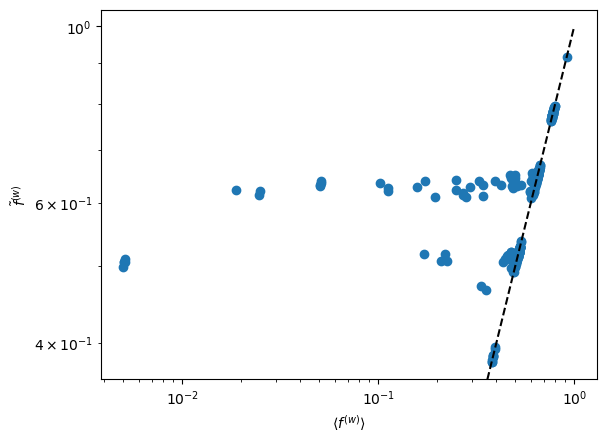

In [26]:
from matplotlib import pyplot as plt
plt.plot(listav, listND, 'o')
plt.xlabel(r'$\langle f^{(w)} \rangle$')
plt.ylabel(r'$\tilde{f}^{(w)}$')
plt.plot([0,1],[0,1], 'k--')
plt.loglog()